In [1]:
#import tools for twitter API
import tweepy
from twitter import *
import pymongo, pprint
from pymongo import MongoClient
#Import everything useful for networks
import networkx as nx
import matplotlib.pyplot as plt
import json
import time
import datetime
import os
import pickle
import elections_helper as helper

In [2]:
# Open the network
directed = pickle.load(open('./graph2.txt'))

## Basic Stats

In [3]:
import numpy as np
%matplotlib inline 

In [4]:
#Number of node
print "The graph has %d nodes" % directed.number_of_nodes() , "and and %d edges "% directed.number_of_edges()


#Top 10 account by in and out degree
node_in_degree_tuples = sorted([(node, directed.in_degree(node)) for node in directed.nodes()], key=lambda (n, d): -d)
node_out_degree_tuples = sorted([(node, directed.out_degree(node)) for node in directed.nodes()], key=lambda (n, d): -d)

print node_in_degree_tuples[:10]
print node_out_degree_tuples[:10]




The graph has 5927 nodes and and 12278 edges 
[(u'wikileaks', 31), (u'BarackObama', 26), (u'realDonaldTrump', 25), (u'BernieSanders', 24), (u'KellyannePolls', 23), (u'HillaryClinton', 22), (u'Snowden', 21), (u'mike_pence', 21), (u'DRUDGE_REPORT', 21), (u'seanhannity', 21)]
[(u'Trevor90666770', 1064), (u'halsteadg048', 885), (u'jojoh888', 677), (u'SanFranMoman', 586), (u'sanchezcan', 551), (u'stuartpstevens', 534), (u'sallykohn', 530), (u'bad_bad_bernie', 523), (u'StevenTDennis', 487), (u'SultryRobin', 475)]


* The following section draws the distribution graphs.

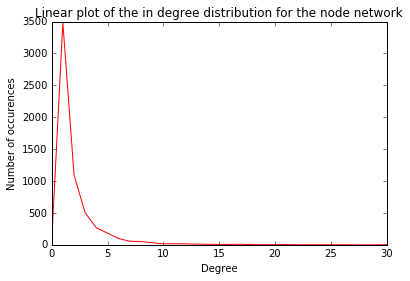

In [5]:
#Distributions
# Compute min and max values for the degrees
node_in_degree = map(lambda x: x[1], node_in_degree_tuples)
node_out_degree = map(lambda x: x[1], node_out_degree_tuples)
max_in_degree = max(node_in_degree)
min_in_degree = min(node_in_degree)
max_out_degree = max(node_out_degree)
min_out_degree = min(node_out_degree)

# Compute the bins for our degree distribution
bins_in = [i for i in range(min_in_degree, max_in_degree+1)]
bins_out = [i for i in range(min_out_degree, max_out_degree+1)]

degrees_in_hist, degrees_in_bin = np.histogram(node_in_degree, bins=bins_in)
degrees_out_hist, degrees_out_bin = np.histogram(node_out_degree, bins=bins_out)

plt.plot(degrees_in_bin[:-1], degrees_in_hist, 'r')
plt.xlabel('Degree')
plt.ylabel('Number of occurences')
plt.title('Linear plot of the in degree distribution for the node network')
plt.show()

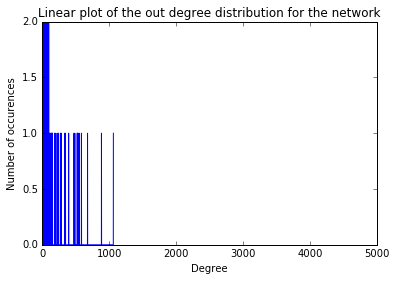

In [6]:
plt.plot(degrees_out_bin[:-1], degrees_out_hist, 'b')
plt.axis([0, 5000, 0, 2])
plt.xlabel('Degree')
plt.ylabel('Number of occurences')
plt.title('Linear plot of the out degree distribution for the network')
plt.show()

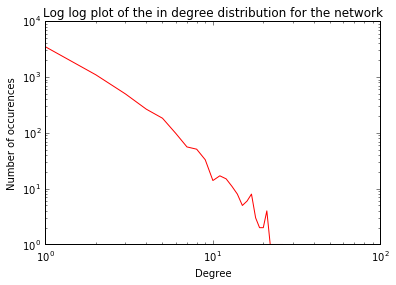

In [7]:
plt.loglog(degrees_in_bin[:-1], degrees_in_hist, 'r')
plt.xlabel('Degree')
plt.ylabel('Number of occurences')
plt.title('Log log plot of the in degree distribution for the network')
plt.show()

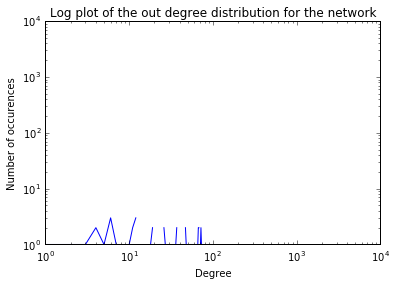

In [8]:


plt.loglog(degrees_out_bin[:-1], degrees_out_hist)
plt.xlabel('Degree')
plt.ylabel('Number of occurences')
plt.title('Log plot of the out degree distribution for the network')
plt.show()



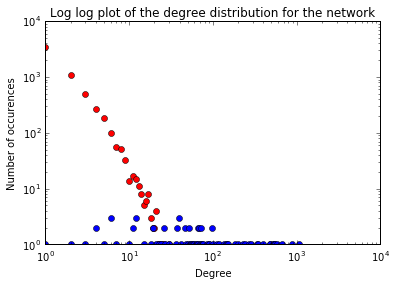

In [9]:
plt.loglog(degrees_in_bin[:-1], degrees_in_hist, 'ro')
plt.loglog(degrees_out_bin[:-1], degrees_out_hist, 'o')
plt.xlabel('Degree')
plt.ylabel('Number of occurences')
plt.title('Log log plot of the degree distribution for the network')
plt.show()

## Centrality and other stuffs

* The following section draws the graph and weigth the size of a node according to its degree. The plot itself is not really important, but it looks cool !

The graph is way too big to be drawn, so we decide to make a smaller graph. The idea is to keep the node with a degree greater than 3 only. We have a lot of isolated accounts that are quite useless in this centrality analysis.

In [10]:
#Compute a list of nodes with a degree < 1 to remove
to_remove = [node for node,degree in directed.degree().items() if degree < 3]

In [11]:
# We make a copy of the original graph
directed_minimized = directed.copy()

In [12]:
#We remove the nodes
directed_minimized.remove_nodes_from(to_remove)

In [13]:
#Number of node
print "The graph has now %d nodes" % directed_minimized.number_of_nodes() , "and and %d edges "% directed_minimized.number_of_edges()


#Top 10 account by in and out degree
node_in_degree_tuples = sorted([(node, directed_minimized.in_degree(node)) for node in directed_minimized.nodes()], key=lambda (n, d): -d)
node_out_degree_tuples = sorted([(node, directed_minimized.out_degree(node)) for node in directed_minimized.nodes()], key=lambda (n, d): -d)
print "The top ten accounts by in degree are : "
print node_in_degree_tuples[:10]
print "The top ten accounts by out degree are : "
print node_out_degree_tuples[:10]

The graph has now 1356 nodes and and 6612 edges 
The top ten accounts by in degree are : 
[(u'wikileaks', 31), (u'BarackObama', 26), (u'realDonaldTrump', 25), (u'KellyannePolls', 23), (u'BernieSanders', 23), (u'HillaryClinton', 22), (u'Snowden', 21), (u'mike_pence', 21), (u'DRUDGE_REPORT', 21), (u'seanhannity', 21)]
The top ten accounts by out degree are : 
[(u'Trevor90666770', 509), (u'sanchezcan', 388), (u'halsteadg048', 334), (u'sallykohn', 323), (u'kurteichenwald', 298), (u'stuartpstevens', 297), (u'jojoh888', 288), (u'StevenTDennis', 285), (u'SultryRobin', 229), (u'PPolenberg', 219)]


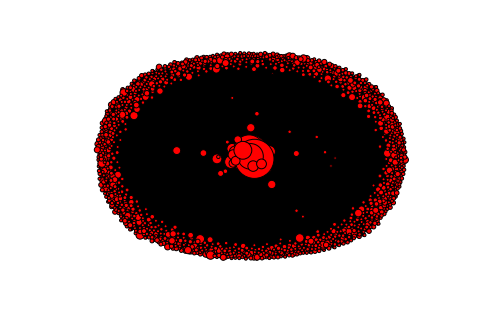

In [14]:
#We can now plot the network 
d = nx.degree(directed_minimized)
nx.draw(directed_minimized, nodelist=d.keys(), node_size=[v * 3 for v in d.values()])
plt.show()

In [15]:
plt.savefig("graph.pdf")

* We will now go through some centrality measures. We perform these algorithms on the reduced network as these measures are very costly 

In [16]:
# We need an undirectd graph
undir = directed_minimized.to_undirected()

In [17]:
#Betweeness centrality
between_centrality = nx.betweenness_centrality(undir)
between_centrality_sorted = sorted(between_centrality.iteritems(), key=lambda (name, value): -value)

print "Betweenes : The 5 most central accounts are :\n" 
print between_centrality_sorted[:5]

Betweenes : The 5 most central accounts are :

[(u'Trevor90666770', 0.2510882516540761), (u'sanchezcan', 0.1180542561900672), (u'sallykohn', 0.1080102812359374), (u'stuartpstevens', 0.1015319179590583), (u'kurteichenwald', 0.09363679411802166)]


In [18]:
#Eigen vectore centrality
eigen_centrality = nx.eigenvector_centrality(undir)
eigen_centrality_sorted = sorted(eigen_centrality.iteritems(), key=lambda (name, value): -value)

print "Eigen : The 5 most central accounts are :\n" 
print eigen_centrality_sorted[:5]

Eigen : The 5 most central accounts are :

[(u'Trevor90666770', 0.27357220536946736), (u'sanchezcan', 0.2467097533373772), (u'kurteichenwald', 0.2307050684639593), (u'sallykohn', 0.1997966865487106), (u'stuartpstevens', 0.19595062465956906)]


In [19]:
#In degree centrality
in_centrality = nx.in_degree_centrality(test)
in_centrality_sorted = sorted(in_centrality.iteritems(), key=lambda (name, value): -value)

print "In degree centrality : The 5 most central accounts are :\n" 
print in_centrality_sorted[:5]

NameError: name 'test' is not defined

In [ ]:
#out degree centrality
out_centrality = nx.out_degree_centrality(test)
out_centrality_sorted = sorted(out_centrality.iteritems(), key=lambda (name, value): -value)

print "out degree centrality : The 5 most central accounts are :\n" 
print out_centrality_sorted[:5]

In [ ]:
#Now we want to check if there is a path between Clinton and Trump on both networks
print nx.has_path(undir, u'HillaryClinton',  u'realDonaldTrump')
print nx.has_path(test, u'HillaryClinton',  u'realDonaldTrump')

In [ ]:
print nx.shortest_path_length(undir, u'HillaryClinton',  u'realDonaldTrump')
print nx.shortest_path_length(undir, u'HillaryClinton',  u'wikileaks')
print nx.shortest_path_length(undir, u'BarackObama',  u'realDonaldTrump')

## Problem importing community 

## Community detection

In [ ]:
import community
undir = dire.to_undirected()

In [ ]:
partition = community.best_partition(undir)

#drawing
size = float(len(set(partition.values())))
pos = nx.spring_layout(undir)
count = 0.5
for com in set(partition.values()) :
    count = count + 1.
    list_nodes = [nodes for nodes in partition.keys()
                                if partition[nodes] == com]
    nx.draw_networkx_nodes(undir, pos, list_nodes, node_size = 20,
                                node_color = str(count / (size)))


nx.draw_networkx_edges(undir,pos, alpha=0.5)
plt.show()

In [ ]:
louvain_modularity = community.modularity(partition, undir)
louvain_modularity

* We got a louvain modularity of 0.4, we can say this modularity is pretty high, which means we have good partitions in our network.


In [ ]:
communities = {}

# Create a dictionary of all communities and their associated user 
for user, community_index in partition.iteritems():
    if community_index in communities:
        communities[community_index].add(user)
    else:
        communities[community_index] = {user}
    
nb_communities = len(communities)
nb_communities

In [ ]:
ind = community.induced_graph(partition, undir)
nx.draw(ind)
plt.show()

* Our network has 7 different communities according to the louvain algorithm

In [ ]:
communities

In [ ]:
com_list = []
for i, c in communities.iteritems():
    com_list.append(c)

In [ ]:
#Top 10 account by in and out degree
for i, c in enumerate(com_list):
    sub = test.subgraph(c)
    node_in_degree_tuples = sorted([(node, sub.in_degree(node)) for node in sub.nodes()], key=lambda (n, d): -d)
    node_out_degree_tuples = sorted([(node, sub.out_degree(node)) for node in sub.nodes()], key=lambda (n, d): -d)
    print("In community ", i)
    print("The top ten accounts by in degree are : ")
    print( node_in_degree_tuples[:10])
    print("The top ten accounts by out degree are : ")
    print( node_out_degree_tuples[:10])
    print("\n")

In [ ]:
for i, c in enumerate(com_list):
    filename = './data_files/community_updated' + str((i+1)) +'.txt'
    with(open(filename, 'w')) as f:
        for screen_name in c:
            f.write(screen_name +'\n')
        f.close()